### PROJECT: Text analysis on medical publications about COVID-19
#### Quy Do - October 2021

This notebook aims to conduct a text information retrieval and text mining on medical research publication regarding Covid19 - treatments and vaccinations.

In [68]:
import pandas as pd     # To handle data
import numpy as np      # For number computing
import plotly.express as px

# For NLP
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, pos_tag,ne_chunk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import Counter

# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

# !pip install pyLDAvis
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import spacy
from spacy.lang.en import English
nlp = spacy.load("en_core_web_lg")

#### 1. Top 10 journals with the publications distribution based on its source
    1.1. Data maniputaltion and sanitisation
    1.2. Visialisation the top 10 journals  
    1.3. Implication
#### 2. Identify main clusters 
    2.1. Data pre-processing
    2.2. Vectorising using tf.idf
    2.3. Dimensional reduction using PCA - The optimal number of cluster
    2.4. Dimensional reduction by t-SNE - The reasonable metric to determine the similarity between abstracts
    2.5. Visualisation of main clusters 
    2.6. Graphical intepretatio   
#### 3. What is the most representative words in each cluster
    3.1. Data pre-processing
    3.2. Wordclouds
    3.3. Interpretation - what are the most representative words 
#### 4. The most common topics 
    4.1. Identify the number of topics - Topic Modelling
    4.2. Graphically display data by pyLDA and interpretation
    4.3. Most representative words in each topic
#### 5. The most common topics in each cluster
    5.1. Identify the main topics of the opinions expressed in the abstracts
    5.2. Identify the most representative clusters of each topic
    5.3. The most representative topics of each cluster
#### *Bonus: Additional information regarding topic modelling and clustering


#### 1. Top 10 journals with the publications distribution based on its source

The purpose of this part is to produce a clustered column chart to show the top 10 frequent journals with the distribution of publications in each journal. Of note, we will transform the distrubition of publications of in log value to normalise the data. For simplicity, we also only keep the first source if a publication has multiple sources.  

**1.1. Data maniputaltion and sanitisation**

We firstly import the dataset **metadata.csv** and save it in the dataframe **data**. 
- This is a large dataset with 19 variables and 76,8929 observations. 
- We can also look closer to the first 5 observations in the dataset. Notice that, there are some columns contain null values such as *title, abstract, authors, journal*, etc. 

In [69]:
data = pd.read_csv("metadata.csv")
data.shape

(768929, 19)

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768929 entries, 0 to 768928
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          768929 non-null  object 
 1   sha               240689 non-null  object 
 2   source_x          768929 non-null  object 
 3   title             768555 non-null  object 
 4   doi               380270 non-null  object 
 5   pmcid             249436 non-null  object 
 6   pubmed_id         330306 non-null  object 
 7   license           768929 non-null  object 
 8   abstract          569842 non-null  object 
 9   publish_time      768703 non-null  object 
 10  authors           751296 non-null  object 
 11  journal           721462 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  365653 non-null  object 
 14  arxiv_id          9487 non-null    object 
 15  pdf_json_files    240689 non-null  object 
 16  pmc_json_files    19

In [71]:
data.head()

cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Data sanitisation/manipulate is necessary for visualisation purposes. 
-  We are interested in finding the top 10 most frequent journals with their publication distribution, thus we will focus mainly on the variables "source_x" and "journal".
- Hence, these 2 variables are saved in a new dataframe **df** for manipulating and plotting purposes. 

In [72]:
df = data[["source_x", "journal"]]
df

source_x              journal
0                          PMC       BMC Infect Dis
1                          PMC           Respir Res
2                          PMC           Respir Res
3                          PMC           Respir Res
4                          PMC           Respir Res
...                        ...                  ...
768924  Elsevier; Medline; PMC       Med Hypotheses
768925            Medline; PMC         BMC Med Educ
768926            Medline; PMC      Eur Phys J Plus
768927  Elsevier; Medline; PMC                Chest
768928            Medline; PMC  Biotechnology (N Y)

[768929 rows x 2 columns]

- There are serveral journals having multiple sources *(i.e. index 768924 - Med Hypotheses has multiple sources: Elsevier, medline, and PMC)*. 


- For simplicity, we will keep the first sources of journals having multiple sources by **split()** method to split all values of column **source_x** by the delimnator **";"** and only keep the first value. The result will be saved in a new column named **split_source** in dataframe **df**. Now, Elsevier is the only source of Med Hypotheses (index 768924) for example. 

In [73]:
df['Source'] = df['source_x'].str.split(';').str[0]
df

source_x              journal    Source
0                          PMC       BMC Infect Dis       PMC
1                          PMC           Respir Res       PMC
2                          PMC           Respir Res       PMC
3                          PMC           Respir Res       PMC
4                          PMC           Respir Res       PMC
...                        ...                  ...       ...
768924  Elsevier; Medline; PMC       Med Hypotheses  Elsevier
768925            Medline; PMC         BMC Med Educ   Medline
768926            Medline; PMC      Eur Phys J Plus   Medline
768927  Elsevier; Medline; PMC                Chest  Elsevier
768928            Medline; PMC  Biotechnology (N Y)   Medline

[768929 rows x 3 columns]

- Next, we want to get a series object containing the count of **unique values** in each column of df. After keeping the first source of journals having multiple sources, we only have 7 uniques sources over 43027 different journals. In which, there are 47,467 null values of column **journal**. 

In [74]:
uniqueValues = df.nunique()
print('Number of unique values:')
print(uniqueValues)

Number of unique values:
source_x       40
journal     43027
Source          7
dtype: int64


In [75]:
df["journal"].isnull().sum()

47467

- For plotting purpose, we need to drop NULL values in column **journal** by using **dropna()** method. 

- After that, we check and confirm that there is no null value in column **journal** as shown below. As a result, df now contains only  72,1462 observations. 

In [76]:
# drop NA values in column journal 
df.dropna(subset = ["journal"], inplace=True)

In [77]:
df["journal"].isnull().sum()

0

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721462 entries, 0 to 768928
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   source_x  721462 non-null  object
 1   journal   721462 non-null  object
 2   Source    721462 non-null  object
dtypes: object(3)
memory usage: 22.0+ MB


Now, we want to find the top 10 journals in our dataset. 
- Applying **value_counts()** method to column journal, we can find the frequency of the journal in the dataset. 
- Then using **sort_value(ascending=False)** we can sort the result in the descending order. 
- Then, slicing to get only the top 10 rows containing the top 10 journals having highest number of frequency.  

In [79]:
top10_names = df['journal'].value_counts()[:10].sort_values(ascending=False)
top10_names 

PLoS One                                        7610
bioRxiv                                         6489
BMJ                                             6097
Sci Rep                                         4137
Int J Environ Res Public Health                 3995
Nature                                          2980
Lancet                                          2942
Int. j. environ. res. public health (Online)    2741
Cureus                                          2639
Viruses                                         2483
Name: journal, dtype: int64

- Now, we want to create a new dataframe to store  observations of the top 10 journals together with theirs sources. 


- Based on the **top10_names** as figure out above, we select and create dataframe **df1** containing journals that match with the names of top 10 journals as below: 

In [80]:
df1 = df.loc[(df['journal'] == 'PLoS One') | (df['journal'] == 'bioRxiv') | (df['journal'] == 'BMJ') |
             (df['journal'] == 'Sci Rep') | (df['journal'] == 'Int J Environ Res Public Health') | 
             (df['journal'] == 'Nature') | (df['journal'] == 'Lancet') |
             (df['journal'] == 'Int. j. environ. res. public health (Online)') | 
             (df['journal'] == 'Cureus') | (df['journal'] == 'Viruses') , :]

In [81]:
df1

source_x   journal   Source
80               PMC  PLoS One      PMC
81               PMC  PLoS One      PMC
82               PMC  PLoS One      PMC
89               PMC  PLoS One      PMC
92               PMC  PLoS One      PMC
...              ...       ...      ...
768884  BioRxiv; WHO   bioRxiv  BioRxiv
768887  BioRxiv; WHO   bioRxiv  BioRxiv
768894  Medline; PMC  PLoS One  Medline
768899  Medline; PMC  PLoS One  Medline
768905  Medline; PMC  PLoS One  Medline

[42113 rows x 3 columns]

- Now, df1 contains 42,113 observations which are needed for our plotting purpose. 

- In order to know the frequency of each journal in each source, we use **groupby()** method in order to group data based on **split_source** and **journal** columns, and show the number of each journal in each source using count() method. Result is shown as below: 

In [82]:
df1 = df1.groupby(["Source","journal"])["journal"].count()
df1

Source    journal                                     
ArXiv     BMJ                                                2
          Int J Environ Res Public Health                    3
          PLoS One                                          30
          Sci Rep                                           11
BioRxiv   bioRxiv                                         6441
Elsevier  Lancet                                           763
          Viruses                                           11
MedRxiv   bioRxiv                                            1
Medline   BMJ                                             3008
          Cureus                                          1425
          Int J Environ Res Public Health                 3655
          Lancet                                           323
          Nature                                          1462
          PLoS One                                        3563
          Sci Rep                                         1769


- In order to convert df1 to dataframe, we use method unstack() applying to column **Source** to returns a dataframe having a new level of column labels whose inner-most level consists of split_source's labels (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html). 

- Using transpose() method, we show a nice dataframe below. 

In [83]:
df1 = df1.unstack("Source")
df1 = df1.transpose()

In [84]:
df1

journal      BMJ  Cureus  Int J Environ Res Public Health  \
Source                                                      
ArXiv        2.0     NaN                              3.0   
BioRxiv      NaN     NaN                              NaN   
Elsevier     NaN     NaN                              NaN   
MedRxiv      NaN     NaN                              NaN   
Medline   3008.0  1425.0                           3655.0   
PMC         11.0     NaN                            336.0   
WHO       3076.0  1214.0                              1.0   

journal   Int. j. environ. res. public health (Online)  Lancet  Nature  \
Source                                                                   
ArXiv                                              NaN     NaN     NaN   
BioRxiv                                            NaN     NaN     NaN   
Elsevier                                           NaN   763.0     NaN   
MedRxiv                                            NaN     NaN     NaN   
Medline                                            NaN   323.0  1462.0   
PMC                                                NaN   435.0   213.0   
WHO                                             2741.0  1421.0  1305.0   

journal   PLoS One  Sci Rep  Viruses  bioRxiv  
Source                                         
ArXiv         30.0     11.0      NaN      NaN  
BioRxiv        NaN      NaN      NaN   6441.0  
Elsevier       NaN      NaN     11.0      NaN  
MedRxiv        NaN      NaN      NaN      1.0  
Medline     3563.0   1769.0   1302.0      NaN  
PMC         1004.0    572.0    285.0      1.0  
WHO         3013.0   1785.0    885.0     46.0

- Of note, there are several NaN values. It indicates that, not all sources public all journals in top 10. For example, **BioRxiv** source publiced only journal named **bioRxiv**, while WHO source publiced almost all journals in top 1 including **BMj, Int J Environ Res Public Health, PloS One** and **Sci Rep** publice **ArXiv** source. 


- Therefore, to indicate the distribution of journals that is NaN in each source, we can replace NaN values by 0 using **fillna()** method. 


In [85]:
df1 = df1.fillna(0)

In [86]:
df1

journal      BMJ  Cureus  Int J Environ Res Public Health  \
Source                                                      
ArXiv        2.0     0.0                              3.0   
BioRxiv      0.0     0.0                              0.0   
Elsevier     0.0     0.0                              0.0   
MedRxiv      0.0     0.0                              0.0   
Medline   3008.0  1425.0                           3655.0   
PMC         11.0     0.0                            336.0   
WHO       3076.0  1214.0                              1.0   

journal   Int. j. environ. res. public health (Online)  Lancet  Nature  \
Source                                                                   
ArXiv                                              0.0     0.0     0.0   
BioRxiv                                            0.0     0.0     0.0   
Elsevier                                           0.0   763.0     0.0   
MedRxiv                                            0.0     0.0     0.0   
Medline                                            0.0   323.0  1462.0   
PMC                                                0.0   435.0   213.0   
WHO                                             2741.0  1421.0  1305.0   

journal   PLoS One  Sci Rep  Viruses  bioRxiv  
Source                                         
ArXiv         30.0     11.0      0.0      0.0  
BioRxiv        0.0      0.0      0.0   6441.0  
Elsevier       0.0      0.0     11.0      0.0  
MedRxiv        0.0      0.0      0.0      1.0  
Medline     3563.0   1769.0   1302.0      0.0  
PMC         1004.0    572.0    285.0      1.0  
WHO         3013.0   1785.0    885.0     46.0

**1.2. Visialisation the top 10 journals**

- To visualise df1 dataframe, we can use grouped bar chart to present the distribution of top 10 journals over their sources. 

- Using library plotly.express imported as px, we can easily create entire figures at once https://plotly.com/python/plotly-express/: 

    + df1 is the dataframe we want to plot 
    + **barmode = "group"**: this argument to indicate that we want to change the default stacked bar chart to grouped/clustered chart.
    + **log_y = True**: this indicate that we want to show the distribution of journals in each souces in log-value, where 10 is $10^1$, 100 is $10^2$, etc. 
    + title: to set the figure title 
    + labels: using **labels** argument to override the default axis and legend labels behaviour. In this case, we want to change the y-axis by setting **'value':'Distribution of Journals (log)**. 
    + category_orders: to override the default category ordering behaviour. In this case, we want to show the different sources in x-axis by their names

In [87]:
px.bar(df1, barmode="group", log_y=True,
       title="Distribution of sources based on top 10 journals", 
       labels={'value':'Distribution of Journals (log)'},
       category_orders={'Sources':['ArXiv','BioRxiv','Elsevier','MedRxiv','Medline', 'PMC', 'WHO']})

**1.3 Implication:**
- The graph illustrates the distribution of top 10 journals in different sources (7 unique sources). 

- Legends on the right handside indicate the top 10 journals. 
- The distribution of the journals is in log-value as shown by y-axis. 

- We can see that many journals in top 10 are from the sources Medlne, PMC and WHO with pretty high distribution meaning that they are popular sources to search for Covid-19 pandemic and treatments. Meanwhile, only 1 or a few journals are distributed in sources BioRxiv, MedRxiv or Elsevier. BioRxiv and MedRxiv only publics **bioRxiv** journal in which BioRxiv has the highest journal distribution and MedRxiv has the lowest journal distribution amongs all sources.  




## 2. Main clusters in the dataset

- In this part, we will cluster the text from **abstract** variable and visualise the clusters. 
- To do so, we will use **Kmeans** clustering method and the **cosine similarity** as a metric to determine the similarity between abstracts. 
- The number of clusters will be decided based on Elbow Method.
- Also, we will reduce the dimensions of the data to 2D-dimension for plotting purpose, in which:
    + the axes represent a 2D representation of each document
    + each document is represented as a marker 
    + the colour of the marker indicates the cluster to which the document belongs.
    
We will conduct the following sub-tasks:

    2.1. Data pre-processing
    2.2. Vectorising using tf.idf
    2.3. Dimensional reduction using PCA/t-SNE - finding the optimal number of cluster
    2.4. What is the reasonable metric to determine the similarity between abstracts?
    2.5. Visualisation of main clusters 
    2.6. Implication   

**2.1. Data pre-processing**

- Due to the computational limitation, we will run this task with a subset of dataset. Using sample() method, we can randomly pick 10,000 observations, setting random_state = 42 for reproductivity. 
- Also, we conduct data pre-processing before doing clusterring to ensure that the words in each cluster are well represent. We will: 
    + remove observations that is not in English (by language detection)
    + remove stopwords & punctuation, 
    + remove redundant words
        
(Note: A compresenive data preprocessing will be conducted in Session 3).


In [88]:
df2 = data[["abstract"]] #create the new dataset containing only column "abstract" for Task 2. 
df2

abstract
0       OBJECTIVE: This retrospective chart review des...
1       Inflammatory diseases of the respiratory tract...
2       Surfactant protein-D (SP-D) participates in th...
3       Endothelin-1 (ET-1) is a 21 amino acid peptide...
4       Respiratory syncytial virus (RSV) and pneumoni...
...                                                   ...
768924  Burnout is a state of physical or mental colla...
768925  BACKGROUND: Pharmacists are often the first he...
768926  In a recent work, we introduced a novel method...
768927                                                NaN
768928                                                NaN

[768929 rows x 1 columns]

- Get the sample dataset. 

In [89]:
df2 = df2.sample(10000, random_state=42, replace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 121958 to 265033
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  7391 non-null   object
dtypes: object(1)
memory usage: 156.2+ KB


- We notice that there are null values in this subset (7391 non-null amongst 10,000 observations), thus, we will drop them by using dropna() method. 

In [90]:
df2.dropna(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7391 entries, 121958 to 265033
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  7391 non-null   object
dtypes: object(1)
memory usage: 115.5+ KB


- Now, df2 contains over 7,391 non-null observations. 
- Besides English, there are multiple languages in our dataset. Therefore, we can handle multiple languages by firstly determine the language of each journal using package langdetect.
- Refering https://www.kaggle.com/maksimeren/covid-19-literature-clustering, https://pypi.org/project/langdetect/. 

In [91]:
# !pip install langdetect
# import langdetect
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# create a list containing languages
languages = []

# create a for loop going through abstract column
for ii in tqdm(range(0,len(df2))):
    # split by space into list, take the first x intex, join with space
    text = df2.iloc[ii]['abstract'].split(" ")
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e: 
            try:
                lang = detect(df2.iloc[ii]['abstract'])
            except Exception as e:
                lang = "unknown"
                pass
    # get the language    
    languages.append(lang)

100%|██████████| 7391/7391 [00:25<00:00, 295.33it/s]


In [92]:
from pprint import pprint
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 7391

{'de': 18,
 'en': 7268,
 'es': 35,
 'fr': 22,
 'id': 2,
 'it': 7,
 'mk': 1,
 'nl': 6,
 'pl': 2,
 'pt': 26,
 'tr': 1,
 'unknown': 1,
 'zh-cn': 2}


- There are different languages in abstract (i.e. de-Deutsch, fr-France, it-Italiano). Hence, we will firstly add the languages list into dataframe df2, and drop all languages that are not English. 
- Now, df2 contains 7,268 abstracts in English.

In [93]:
df2['language'] = languages
df2 = df2[df2['language'] == 'en'] 
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7268 entries, 121958 to 265033
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  7268 non-null   object
 1   language  7268 non-null   object
dtypes: object(2)
memory usage: 170.3+ KB


**Remove stopwords and punctuations:** 
- We want to find and remove stopwords and punctuation in abstract column (common words that will act as noise in the clustering step).

In [94]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk_stopwords = stopwords.words('english')
print(nltk_stopwords) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /Users/quydo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
#remove stopwords
df2['abstract_cleaned'] = df2['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (nltk_stopwords)]))
df2.head()

abstract language  \
121958  Dehydroandrographolide succinate (DAS) injecti...       en   
671155  Background As of January 19, 2021, around two ...       en   
131932  BACKGROUND Diabetes mellitus is an endocrine m...       en   
365838  A recent Consumer Reports survey of 60,000 rea...       en   
644167  In the context of the major potential impacts ...       en   

                                         abstract_cleaned  
121958  Dehydroandrographolide succinate (DAS) injecti...  
671155  Background As January 19, 2021, around two mil...  
131932  BACKGROUND Diabetes mellitus endocrine metabol...  
365838  A recent Consumer Reports survey 60,000 reader...  
644167  In context major potential impacts COVID-19 ag...

In [96]:
import string
punctuations = string.punctuation
print(punctuations) 

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [97]:
#remove punctuation
df2['abstract_cleaned'] = df2['abstract_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (punctuations)]))
df2.head()

abstract language  \
121958  Dehydroandrographolide succinate (DAS) injecti...       en   
671155  Background As of January 19, 2021, around two ...       en   
131932  BACKGROUND Diabetes mellitus is an endocrine m...       en   
365838  A recent Consumer Reports survey of 60,000 rea...       en   
644167  In the context of the major potential impacts ...       en   

                                         abstract_cleaned  
121958  Dehydroandrographolide succinate (DAS) injecti...  
671155  Background As January 19, 2021, around two mil...  
131932  BACKGROUND Diabetes mellitus endocrine metabol...  
365838  A recent Consumer Reports survey 60,000 reader...  
644167  In context major potential impacts COVID-19 ag...

- **Remove redundant characters**: We can also create a function clean_text to:

    (i) lower the word
    
    (ii) remove redundant words such as word having single character or 2 characters which will not be much meaningful *(i.e. a, an, as, of, in, etc)*; 
    
    (iii) removing number, etc. 

In [98]:
import re
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[^a-zA-Z]',' ', text)
    text = re.sub('\w*\d\w*',' ', text)            #remove single characters and numbers
    text = re.sub('[0-9]+',' ', text)              #remove numbers
    text = re.sub(r'\b\w{1,2}\b', ' ', text)       #remove words of up to 2 characters
    return text

In [99]:
df2['abstract_cleaned'] = df2['abstract_cleaned'].apply(lambda x: clean_text(x))
df2[['abstract','abstract_cleaned']].head()

abstract  \
121958  Dehydroandrographolide succinate (DAS) injecti...   
671155  Background As of January 19, 2021, around two ...   
131932  BACKGROUND Diabetes mellitus is an endocrine m...   
365838  A recent Consumer Reports survey of 60,000 rea...   
644167  In the context of the major potential impacts ...   

                                         abstract_cleaned  
121958  dehydroandrographolide succinate  das  injecti...  
671155  background   january           around two mill...  
131932  background diabetes mellitus endocrine metabol...  
365838    recent consumer reports survey        reader...  
644167    context major potential impacts covid    agr...

**2.2. Vectorising using tf.idf**

Now, we want to convert the text into a format that can be handled by our algorithms. 

For this purpose, we will be using **tf-idf** feature extraction (a bag of words). It helps convert a collection of raw documents to a matrix of TF-IDF features, showing how important each word is to the instance out of the literature as a whole.
(https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- Create an instance of sklearn's TfidfVectorizer. 
- Fit and trainsform it with the **abstract_cleaned**.
- Now, we can obtain the tf.idf vectors named **idf_vector** for abstracts.

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

idf_vectorizer = TfidfVectorizer(stop_words="english")
idf_vector = idf_vectorizer.fit_transform(df2.abstract_cleaned)
idf_vector

<7268x36524 sparse matrix of type '<class 'numpy.float64'>'
	with 614460 stored elements in Compressed Sparse Row format>

**2.3. Applying PCA for dimension reduction and find the optimal number of clusters**

- Firstly, we can reduce dimension by PCA to reduce the complexity of the high-dimensional data while still keeping 95% variance (n_components=0.95). 

In [101]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95, random_state = 42)
X_pca= pca.fit_transform(idf_vector.toarray())
X_pca.shape

(7268, 5125)

- Next, we can find the best k-value for k-means clustering using Elbow Method. The “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point (refering: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html).



- We are using yellowbrick package and KelbowVisualizer to create Elbow plot, particularly: 

    + With over 10,000 observations, for prudent, we will try the number of clusters ranging from **2 - 25**. 
    + **scoring parameter metric - distortion**: it is the default scoring parameter metric. This metric computes the sum of squared distances from each point to its assigned center. 
    + **locate_elbowbool = True**: will help us automatically find the “elbow” or “knee” which likely corresponds to the **optimal value of k** using the “knee point detection algorithm”. *The knee point detection algorithm finds the point of maximum curvature, which in a well-behaved clustering problem also represents the pivot of the elbow curve. The point is labeled with a dashed line and annotated with the score and k values*.



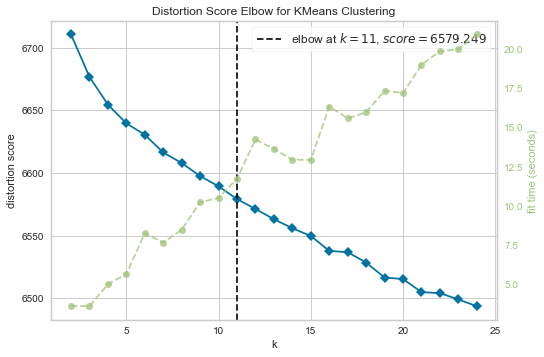

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [102]:
#!pip install yellowbrick
#import yellowbrick.cluster
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, 
                              k=(2,25), 
                              locate_elbowbool=True)

visualizer.fit(X_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

- The "knee point detection algorithm" shows the optimal number of clusters is 13 (a good combination between the distortion scoe and fit time (seconds). We now build the k-means cluster for our dataset with number of clusters **n_clusters=13**, and fit it to **X_pca**. 

**! Disclaimer: the k value is varied each running time. The interpretation and working steps are following the number of cluster = 13**

**Kmeans clustering**

- We now build the k-means cluster for our dataset with number of clusters n_clusters=13, and fit it to X_pca.

- Kmeans clustering is an algorithms using for unsupervised data, helping us to identify the centroids of each cluster and allocate data point to its nearest centroid.
https://scikit-learn.org/stable/modules/clustering.html#k-means


In [103]:
#fit - Compute k-means clustering
model = KMeans(n_clusters=13, random_state=42)
kmeans = model.fit_predict(X_pca) 

In which, kmeans containing the labels of clusters. Hence, we can create new column named Cluster_pca in our dataframe to show the cluster each observation belongs to.  

In [104]:
#obtain the label of cluster for each observation
df2['Cluster_pca'] = kmeans
df2

abstract language  \
121958  Dehydroandrographolide succinate (DAS) injecti...       en   
671155  Background As of January 19, 2021, around two ...       en   
131932  BACKGROUND Diabetes mellitus is an endocrine m...       en   
365838  A recent Consumer Reports survey of 60,000 rea...       en   
644167  In the context of the major potential impacts ...       en   
...                                                   ...      ...   
156810  The outbreak of COVID-19 has currently been un...       en   
19731   BACKGROUND: In addition to rotavirus and norov...       en   
665491  The coronavirus disease (COVID-19) pandemic ha...       en   
185169  At least 38 viral species are transmitted by t...       en   
265033  Evaluation of population-based COVID-19 contro...       en   

                                         abstract_cleaned  Cluster_pca  
121958  dehydroandrographolide succinate  das  injecti...            4  
671155  background   january           around two mill...           12  
131932  background diabetes mellitus endocrine metabol...            0  
365838    recent consumer reports survey        reader...            8  
644167    context major potential impacts covid    agr...            5  
...                                                   ...          ...  
156810  the outbreak covid    currently control china ...            8  
19731   background    addition rotavirus norovirus  hu...           11  
665491  the coronavirus disease  covid     pandemic re...            5  
185169    least    viral species transmitted ticks  vi...            4  
265033  evaluation population based covid    control m...            2  

[7268 rows x 4 columns]

**2.4. Dimensional reduction by t-SNE - The reasonable metric to determine the similarity between abstracts** 

- For visualization purpose, we will use the t-SNE (T-distributed Stochastic Neighbor Embedding), so called nonlinear dimensionality reduction in order to reduce high dimensional features vector to 2 dimensions. Using t-SNE, the similarities between data points will be converted to joint probabilities and minimise the divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data (refering: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=t%20sne#sklearn.manifold.TSNE, https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a). 

- In which: 

    - n_components=2: reduce high-dimensional data into 2 dimensions, default value. 
    - verbose = 1 : will show you an animated progress bar
    - perplexity = 50: related to the number of nearest neighbors that is used in other manifold learning algorithms (normally ranging from 5-50). Larger datasets usually require a larger perplexity. 
    
- Then we can fit and transform idf_vector to create object **X_2d** as below. 

In [105]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50) 
X_2d = tsne.fit_transform(idf_vector.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7268 samples in 0.072s...
[t-SNE] Computed neighbors for 7268 samples in 29.694s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7268
[t-SNE] Computed conditional probabilities for sample 2000 / 7268
[t-SNE] Computed conditional probabilities for sample 3000 / 7268
[t-SNE] Computed conditional probabilities for sample 4000 / 7268
[t-SNE] Computed conditional probabilities for sample 5000 / 7268
[t-SNE] Computed conditional probabilities for sample 6000 / 7268
[t-SNE] Computed conditional probabilities for sample 7000 / 7268
[t-SNE] Computed conditional probabilities for sample 7268 / 7268
[t-SNE] Mean sigma: 0.496480
[t-SNE] KL divergence after 250 iterations with early exaggeration: 181.468903
[t-SNE] KL divergence after 1000 iterations: 4.080066


**Size of clusters**
- We can also observe the distribution of obseveratsion in each cluster by using method groupby().

In [106]:
distribution = df2.groupby("Cluster_pca")["abstract"].count()
distribution

Cluster_pca
0      772
1      185
2      436
3      193
4      840
5      717
6      513
7      128
8     2193
9      502
10      78
11     222
12     489
Name: abstract, dtype: int64

- The number of observations are divided quite equally in each cluster, except for cluster 8 having the highest number of observations (2193) where cluster 10 only include 78 observations. 

**Reasonable metric to determine the similarity between abstracts:**

- Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. Using cosine similarty in text analysis is an appropriate way as the magnitude of vectors is not considered as an important factor. In fact, in text analysis, data is repersented by word counts. Depending on the length of the documents, the frequency of a word in a document might be different but it does not mean that document have higher frequency of a word is more relevant to that word than other documents. The magnitude of the count is less important. 


- A cosine value of 0 means that the two vectors are at 90 degrees to each other (orthogonal) and have no match. The closer the cosine value to 1, the smaller the angle and the greater the match between vectors. Therefore, the higher the cosine similarity, the lower distances between two documents, indicating that the two documents are more similar to each other.  


- Refering: 
    + https://en.wikipedia.org/wiki/Cosine_similarity
    + https://blog.exploratory.io/demystifying-text-analytics-finding-similar-documents-with-cosine-similarity-e7b9e5b8e515  
    
    
- We can identify the similarity between abstracts as below: 



In [107]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(X_pca)

array([[ 1.        , -0.0249224 , -0.00539731, ..., -0.01775762,
        -0.00226411,  0.00746326],
       [-0.0249224 ,  1.        , -0.00886212, ...,  0.00473387,
        -0.02763852,  0.03434462],
       [-0.00539731, -0.00886212,  1.        , ...,  0.01367726,
        -0.01296898,  0.06180587],
       ...,
       [-0.01775762,  0.00473387,  0.01367726, ...,  1.        ,
        -0.01110498,  0.04017053],
       [-0.00226411, -0.02763852, -0.01296898, ..., -0.01110498,
         1.        , -0.0128596 ],
       [ 0.00746326,  0.03434462,  0.06180587, ...,  0.04017053,
        -0.0128596 ,  1.        ]])

**2.5. Visualisation of main clusters**

Finally, we will use pyplot and seaborn packages to plot the desired graph of clusters. 

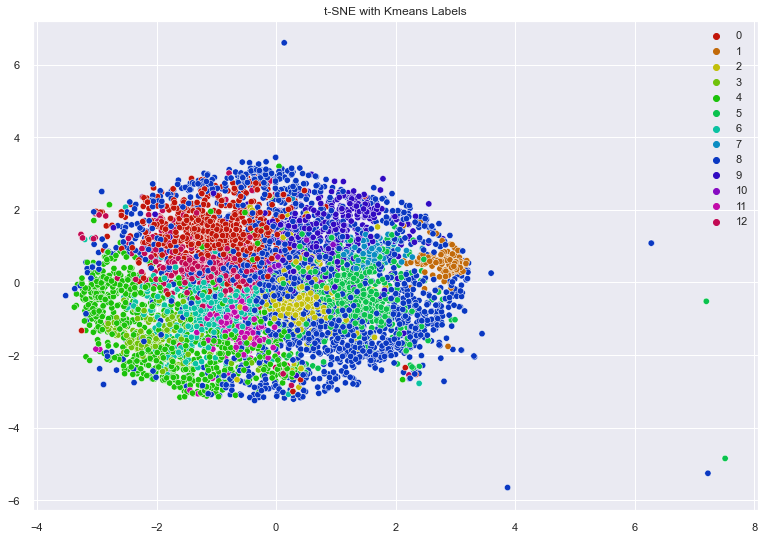

In [108]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(13, l=.4, s=.9)

# plot
sns.scatterplot(X_2d[:,0], X_2d[:,1], hue=kmeans, s=40, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("trial.png")
plt.show()

2.6. Graphical intepretation: 

By reducing the high-dimensional data into 2-D data using t-sne, we can visualize the clusters of documents in the dataset. 

- In general, the K-means clustering is doing a good job in clustering text documents. The plot show the distribution of abstract into different 13 clusters, with the lables of clusters from 0 - 12 in the bottom left hand side of the plot. Particularly, the x and y axis represent a 2D representation of each observation. Each abstract text is shown as a marker with different colors indicating the cluster that the abstract belongs to. 


- There are several clusters which are very easy to identify such as cluster 0 (red), cluster 1 (brown), cluster 2 (yellow). 


- Having said that, there is quite a bit of overlapping between clusters. Some observations from cluster 8 (having the most observations) are spreading all the graph. Furthermore, many outliers spread around the scatter area. For example, cluster 1 (in red , located in the bottom of the graph) has outliers speading to the very top of the graph. Similarly, cluster 11 (in purple, located in the middle of the graph) has outliers speading to the very left hand side of the scatter area.

## Part 3 - Finding the most representative words in each cluster
- In this task, we want to build a word cloud for each cluster so that the size of each word in a word cloud represents the importance of the word in the corresponding cluster. 
- Before doing so, we want to preprocessing our data so that the word displayed are informative. We will: 

**3.1. Data pre-processing**: Besides removing stopwords, puncuations, numbers and redundant words in preivous task, we will conduct lemmatization.  
**3.2. Wordclouds**
   + build the word clouds
   + identify words that do not contribute to wordclouds (repeated words, redundant words)
   + re-create wordclouds.  
   
**3.3. Interpretation - what are the most representative words**

**3.1. Data pre-processing**

**Lemmatization** 

- We will use **spacy** library and *en_core_sci_lg* - a model for processing biomedical, scientific or clinical to convert each word from inflected forms into its original form. 

- Particularly, lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma or dictionary form. For example, words like "reports" and "reporting" are converted to "report" to avoid having words with similar meanings in our data. 

- We want to apply lemmatization instead of the stemming because lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.

https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

In [109]:
def lemma(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [110]:
df2['abstract_cleaned'] = df2['abstract_cleaned'].apply(lambda x: lemma(x))
df2.head()

abstract language  \
121958  Dehydroandrographolide succinate (DAS) injecti...       en   
671155  Background As of January 19, 2021, around two ...       en   
131932  BACKGROUND Diabetes mellitus is an endocrine m...       en   
365838  A recent Consumer Reports survey of 60,000 rea...       en   
644167  In the context of the major potential impacts ...       en   

                                         abstract_cleaned  Cluster_pca  
121958  dehydroandrographolide succinate   das   injec...            4  
671155  background    january            around two mi...           12  
131932  background diabetes mellitus endocrine metabol...            0  
365838     recent consumer report survey         reade...            8  
644167     context major potential impact covid     ag...            5

**3.2. Wordclouds**

**Build the word clouds**: Use matplotlib library and wordcloud to produce word clouds for each cluster.

In [111]:
%matplotlib inline
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

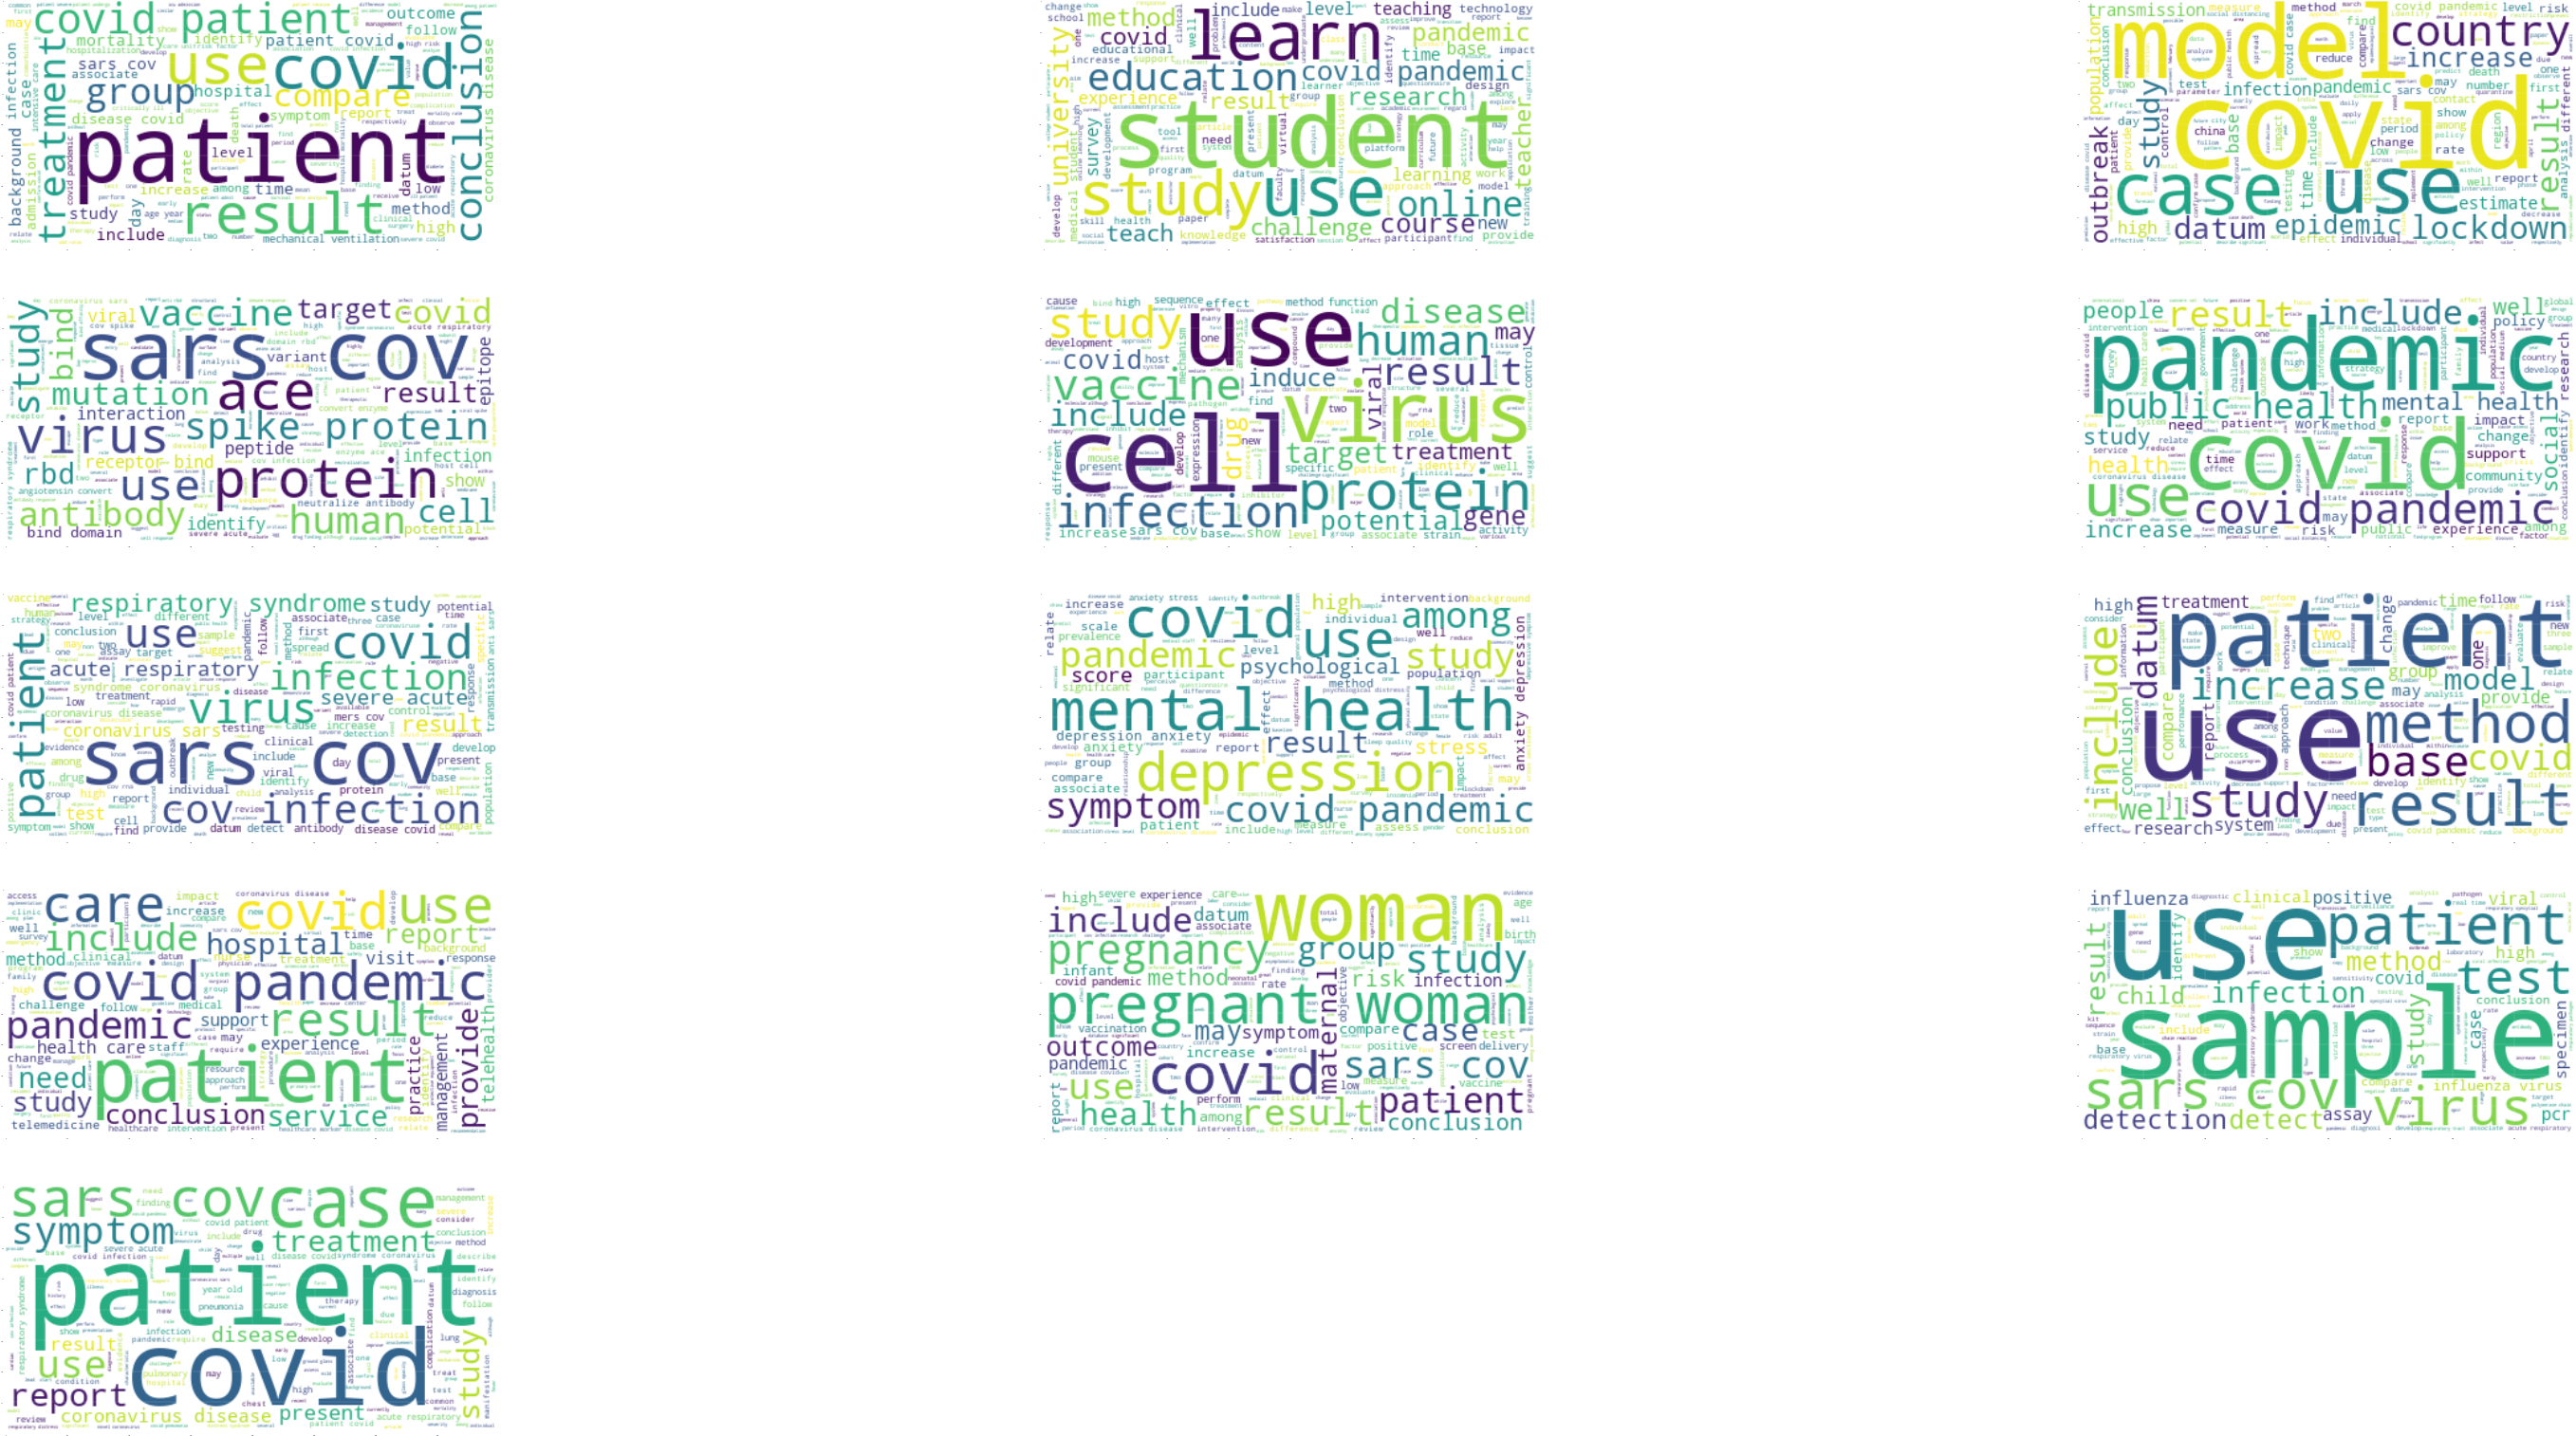

In [112]:
plt.figure(figsize=(400,200), dpi=10)
for cluster_id in range(13):
    plt.subplot(5,3, cluster_id+1)
    text = ' '.join(df2[df2.Cluster_pca==cluster_id].abstract_cleaned)
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')

**Identify words that do not contribute to wordclouds (repeated words, redundant words)**: From the above word clouds, we can identify some words that are repeated over several clouds such as **"patient", "use", "covid", "cov", "sars", "virus", "pandemic"**. Also, there are other words are normally used in literacy such as **"study", "result", "include", "conclusion", "the", "this"** which should be removed. Containing these words in wordclouds might create a misrepresentative of words for each cluster. Therefore, we will remove these words before conducting the word clouds.  

In [113]:
custom_stop_words = ["patient", "use", "covid", "cov", "sars", "virus", "pandemic", #most repeated words
                     "study", "result", "include", "conclusion", "the", "this"] #redundant words in literacy

In [114]:
#remove custome_stop_words
df2['abstract_cleaned'] = df2['abstract_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stop_words)]))
df2.head()

abstract language  \
121958  Dehydroandrographolide succinate (DAS) injecti...       en   
671155  Background As of January 19, 2021, around two ...       en   
131932  BACKGROUND Diabetes mellitus is an endocrine m...       en   
365838  A recent Consumer Reports survey of 60,000 rea...       en   
644167  In the context of the major potential impacts ...       en   

                                         abstract_cleaned  Cluster_pca  
121958  dehydroandrographolide succinate das injection...            4  
671155  background january around two million fatality...           12  
131932  background diabetes mellitus endocrine metabol...            0  
365838  recent consumer report survey reader report li...            8  
644167  context major potential impact agriculture agr...            5

**Re-produce the new wordclouds for each cluster as below:**

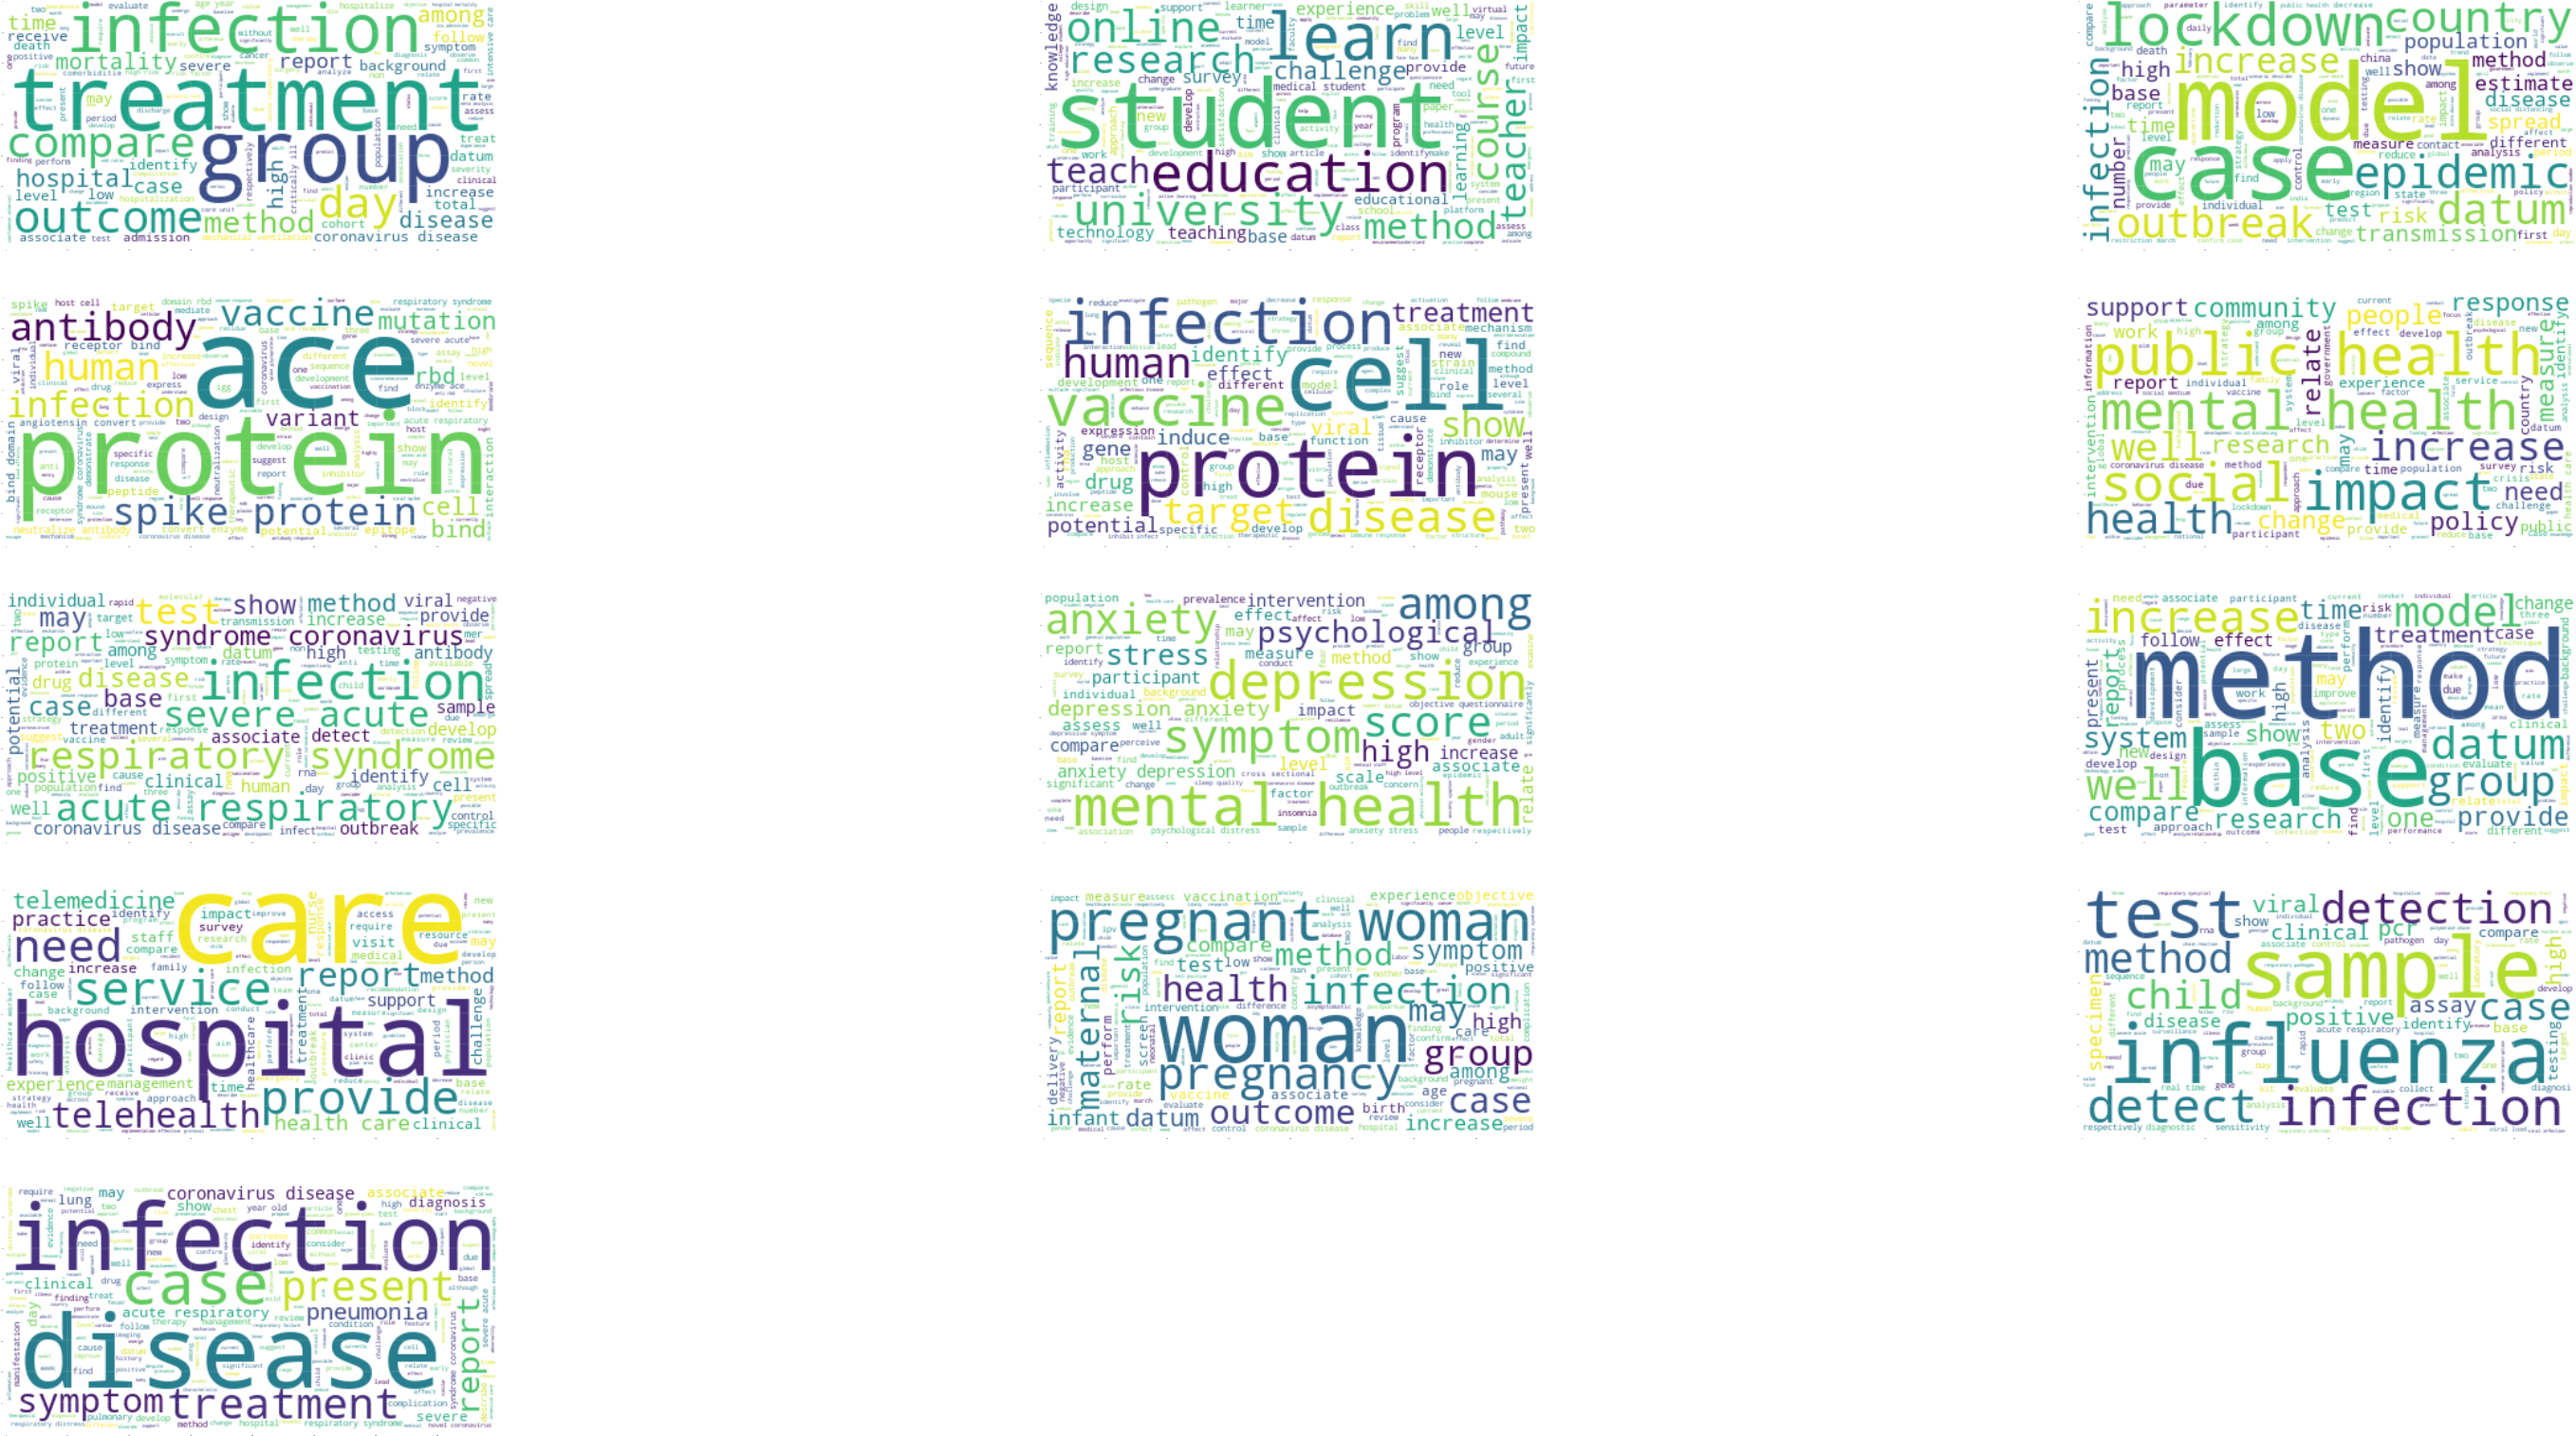

In [115]:
plt.figure(figsize=(400,200), dpi=10)
for cluster_id in range(13):
    plt.subplot(5,3, cluster_id+1)
    text = ' '.join(df2[df2.Cluster_pca==cluster_id].abstract_cleaned)
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')

**3.3. Interpretation - what are the most representative words**

**Wordclouds intepretation**

- In the wordclouds above, the size of the word indicate the frequency in each cluster. 
- After removing common words across clusters and redundant words, we can easily identify  important words in each wordcloud. The words are almost different across all clusters, meaning that they are well-represented the meanings/contents of each cluster. This is a good indicator for meaningful clusters.

**The most representative words in each clusters**.

- Using groupby() method, we can group the observations based on their allocated cluster, then using count() method to identify the frequency of each word in each cluster. Afterthat, we can select top 10 most representative words of each cluster. 

In [116]:
top_term = df2.groupby('Cluster_pca')['abstract_cleaned'].apply(lambda x: x.str.split(expand=True).stack().value_counts().head(10)).reset_index(name='frequency')
top_term = top_term.rename({'level_1': 'top_words'}, axis=1)
top_term.T

0      1          2        3     4         5       6    \
Cluster_pca        0      0          0        0     0         0       0   
top_words    disease  group  mortality  outcome  high  hospital  severe   
frequency        970    862        855      805   803       759     729   

                  7     8    9    ...      120   121          122  \
Cluster_pca         0     0    0  ...       12    12           12   
top_words    clinical  risk  day  ...  disease  case  respiratory   
frequency         697   682  676  ...      753   532          468   

                     123        124       125    126     127     128       129  
Cluster_pca           12         12        12     12      12      12        12  
top_words    coronavirus  infection  clinical  acute  severe  report  syndrome  
frequency            430        409       405    396     377     333       309  

[3 rows x 130 columns]

- The dataframe top_terms includes top 10 words of all 13 clusters. (For example, **disease** is the most common word in cluster 0). 

- Most 10 representative words for each clusters with the word frequency are shown below. For example: 
    + Cluster 1: diseease, group, mortality, outcome, high, hospital, severe, clinical, risk, day
    + Cluster 2: student, learn, online, education, learning, university, medical, course, teaching, health
    
    ....
    
    + Cluster 12: respiratory, sample, infection, pcr, test, influenza, viral, positive, detection, child
    + Cluster 13: desease, case, respiratory, coronavirus, infection, clinical, acute, severe, report, syndrom


In [117]:
print(f"Cluster 1: \n {top_term.iloc[:10]}")   
print(f"Cluster 2: \n {top_term.iloc[10:20]}")   
print(f"Cluster 3: \n {top_term.iloc[20:30]}")   
print(f"Cluster 4: \n {top_term.iloc[30:40]}")   
print(f"Cluster 5: \n {top_term.iloc[40:50]}")   
print(f"Cluster 6: \n {top_term.iloc[50:60]}")   
print(f"Cluster 7: \n {top_term.iloc[60:70]}")   
print(f"Cluster 8: \n {top_term.iloc[70:80]}")   
print(f"Cluster 9: \n {top_term.iloc[80:90]}")   
print(f"Cluster 10: \n {top_term.iloc[90:100]}")   
print(f"Cluster 11: \n {top_term.iloc[100:110]}")   
print(f"Cluster 12: \n {top_term.iloc[110:120]}")   
print(f"Cluster 13: \n {top_term.iloc[120:130]}")   

Cluster 1: 
    Cluster_pca  top_words  frequency
0            0    disease        970
1            0      group        862
2            0  mortality        855
3            0    outcome        805
4            0       high        803
5            0   hospital        759
6            0     severe        729
7            0   clinical        697
8            0       risk        682
9            0        day        676
Cluster 2: 
     Cluster_pca   top_words  frequency
10            1     student        678
11            1       learn        335
12            1      online        276
13            1   education        268
14            1    learning        204
15            1  university        140
16            1     medical        138
17            1      course        126
18            1    teaching        125
19            1      health        115
Cluster 3: 
     Cluster_pca  top_words  frequency
20            2       case        813
21            2      model        631
22         

### 4 - The most common topics

We conducted the topic modelling using Latent Dirichlet Allocation to identify the main topics in the dataset. 

    4.1. Identify the number of topics - Topic Modelling
    4.2. Graphically displaying by pyLDA and interpretation
    4.3. Most representative words in each topic


**4.1. Identify the number of topics - Topic Modelling**

- We applied a machine learning algorithm, LDA ( Latent Dirichlet Allocation) to explore topics presented in the abstract. LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words. The output is the number of topics across all the questions in the data and the theme of each topic.
https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd

- In order to use LDA, it is important to **create document word matrix** and **identify the number of topics**. 

**Create document word matrix by CountVectorizer**

Based on its nature, LDA algorithm needs to use count vectors. CountVectorizer is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text (implements both tokenization and occurrence counting in a single class). https://scikit-learn.org/stable/modules/feature_extraction.html

In [118]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# the vectorizer object will be used to transform text to vector form
count_vector = CountVectorizer(min_df=5, #minimum reqd occurences of a word
                             max_df=0.9, 
                             stop_words='english', 
                             lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')

data_vectorized = count_vector.fit_transform(df2["abstract_cleaned"])
data_vectorized.shape 

# feature_names tells us what word each column in the matric represents
feature_names = count_vector.get_feature_names()

**Identify number of topics**
- In order to choose the best number of topic, we will use the perplexity and log likelihood value as idicators. 
    + **Perplexity**: The lower the perplexity value, the better the model. 
    + **Log Likelihood**: We will pick model having the highest value of log likelihood.
    
    
- In our case, we will randomly run differnt LDA models with differnt number of topics ranging from 8-14, step = 2. https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#11howtogridsearchthebestldamodel

In [119]:
lda_model8 = LatentDirichletAllocation(n_components=8,
                                       learning_method='online', random_state=0, evaluate_every = -1, n_jobs = -1)                                  
model8 = lda_model8.fit_transform(data_vectorized) 

lda_model10 = LatentDirichletAllocation(n_components=10, 
                                        learning_method='online', random_state=0, evaluate_every = -1,n_jobs = -1) # Use all available                     
model10 = lda_model10.fit_transform(data_vectorized) 

lda_model12 = LatentDirichletAllocation(n_components=12, 
                                 learning_method='online', random_state=0, evaluate_every = -1,n_jobs = -1)
model12 = lda_model12.fit_transform(data_vectorized)

lda_model14 = LatentDirichletAllocation(n_components=14, 
                                 learning_method='online', random_state=0, evaluate_every = -1,n_jobs = -1)
model14 = lda_model14.fit_transform(data_vectorized) 

print("Log Likelihood 8: ", lda_model8.score(data_vectorized))
print("Log Likelihood 10: ", lda_model10.score(data_vectorized))
print("Log Likelihood 12: ", lda_model12.score(data_vectorized))
print("Log Likelihood 14: ", lda_model14.score(data_vectorized))

print("Perplexity 8: ", lda_model8.perplexity(data_vectorized))
print("Perplexity 10: ", lda_model10.perplexity(data_vectorized))
print("Perplexity 12: ", lda_model12.perplexity(data_vectorized))
print("Perplexity 14: ", lda_model14.perplexity(data_vectorized))

Log Likelihood 8:  -5574378.416127082
Log Likelihood 10:  -5572902.677862766
Log Likelihood 12:  -5573819.990558315
Log Likelihood 14:  -5574029.261594657
Perplexity 8:  1773.3219302390264
Perplexity 10:  1769.813543047334
Perplexity 12:  1771.9935245671804
Perplexity 14:  1772.491230476723


With the highest log-likelihood (-5572902.678) and lowest perplexity score (1769.814), **the optimal number of topics for our dataset is 10**. 

*Of note, we can use gensim library to conduct LDA and compute the coherence score to pick the best number of topics. 
However, for simplicity, we will accept perplexity as an indicator for model selection, eventhough it is not the best metric as the context and semantic associations between words are not considered.*

**4.2.Graphically displaying by pyLDA**


In [120]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model10, data_vectorized, count_vector, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  13.177597
0       0.648955  71.707100       2        1  11.742255
7      71.019684   9.971006       3        1  11.277122
8       3.785981  33.185135       4        1  11.230112
3     -42.666500  -9.222070       5        1  10.103428
6      -3.621689 -43.526516       6        1   9.949692
9      -3.632402  -4.171708       7        1   9.017331
1     -36.584400  35.804413       8        1   8.126634
4      44.391380  50.615383       9        1   7.846346
5      40.235809 -31.591665      10        1   7.529481, topic_info=           Term         Freq        Total Category  logprob  loglift
1032       cell  2276.000000  2276.000000  Default  30.0000  30.0000
3166     health  4385.000000  4385.000000  Default  29.0000  29.0000
2037    disease  5009.000000  5009.000000  Default  28.0000  28.0000
972        care  2723.000000  2723.000000  Default  27.0000  27.0000
5700    protein  1544.000000  1544.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1960  different   190.255152  1378.782986  Topic10  -5.6867   0.6058
4047      level   199.354728  2240.207766  Topic10  -5.6399   0.1671
6153   response   188.516576  1827.749861  Topic10  -5.6958   0.3147
3231       high   187.552286  3547.494787  Topic10  -5.7010  -0.3536
5467  potential   181.596495  1352.445333  Topic10  -5.7332   0.5785

[778 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3         3  0.994886  abdominal
6         9  0.986165   ablation
14        8  0.983781    abridge
26        1  0.078834   abstract
26        2  0.095728   abstract
...     ...       ...        ...
7870      8  0.004525       year
7870      9  0.042731       year
7870     10  0.001508       year
7880      4  0.984996      youth
7893      9  0.983466   zoonotic

[2078 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 8, 9, 4, 7, 10, 2, 5, 6])

**Graphical Intepretation**: 

- Generally, the graph show a successful topic modelling.


- There is no overlapping bubbles throughout the graph. The size of the bubble is quite similar amongs different topics. Also, they are scattered over the 4 quandrant. All of these signs indicate a good topic modelling. 


- On the left-hand side of the plot, the bubbles represent topics. The size of the bubble represent the widespread of the topic. In our case, **bubble number 1 is the most prevalent topic** with 13.2% distributed tokens. 


- On the right hand side, the keywords and their frequency of each topics are shown if we hover over the topics. 


- We observe that each document covers several topics. This is normal when the documents are fairly large. The topics might have overlaps words but in the visualisation from piLDAvis, it is not too extreme. In fact, hardly any keywords are repeated in multiple topics. This is also an indicator of a good number of topics.

**4.3. Most representative words in each topic**

From the output of LDA model (model10), we can show the most representative words in each topic. In this case, we want to show top 20 keywords of each topic. 

In [121]:
#source: https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
def topics_keywords(vectorizer=count_vector, lda_model=lda_model10, n_words=20):
    keywords = np.array(count_vector.get_feature_names())
    keywords_of_topics = []
    for topic_weights in lda_model.components_:
        toppers_keyword = (-topic_weights).argsort()[:n_words]
        keywords_of_topics.append(keywords.take(toppers_keyword))
    return keywords_of_topics

keywords_topics = topics_keywords(vectorizer=count_vector, lda_model=lda_model10, n_words=20)

df_keywords_topics = pd.DataFrame(keywords_topics)
df_keywords_topics.columns = ['Word '+str(i) for i in range(df_keywords_topics.shape[1])]
df_keywords_topics.index = ['Topic '+str(i) for i in range(df_keywords_topics.shape[0])]
df_keywords_topics.T


Topic 0      Topic 1     Topic 2     Topic 3       Topic 4  \
Word 0       disease     research      health       model       disease   
Word 1        severe       online      social        case     infection   
Word 2     treatment  information     country      number   coronavirus   
Word 3      clinical         base      public       datum   respiratory   
Word 4     mortality      article      impact        rate         human   
Word 5     infection      provide      policy        time          drug   
Word 6         acute        datum      change      period      outbreak   
Word 7     associate         user       paper      method  transmission   
Word 8          risk      student       model    increase        spread   
Word 9   respiratory       review       world     compare         cause   
Word 10      outcome    education    economic    estimate         china   
Word 11  coronavirus   technology  government     measure        review   
Word 12      therapy        learn        time       death      syndrome   
Word 13     syndrome       method      crisis  population      pathogen   
Word 14         high     approach      global    lockdown    infectious   
Word 15         case    challenge        base    epidemic        severe   
Word 16        cause      program      people        base           new   
Word 17      present         tool     measure      cancer         novel   
Word 18     increase      virtual       level       march       control   
Word 19       report       design    approach        high      identify   

               Topic 5       Topic 6    Topic 7     Topic 8      Topic 9  
Word 0            cell   participant      group      health      protein  
Word 1          tissue      analysis       test        care        viral  
Word 2      expression         group        day  healthcare      vaccine  
Word 3          induce          high   positive     service     antibody  
Word 4          effect           age   hospital     medical          rna  
Word 5            lung         woman       case        risk         cell  
Word 6           mouse        health     method      worker       target  
Word 7        increase       symptom  infection      survey         bind  
Word 8       mechanism        report        age  experience     response  
Word 9           model        effect       year        need    infection  
Word 10       function         trial        pcr    practice         drug  
Word 11         signal       outcome    symptom        face         gene  
Word 12           role       anxiety       high     support          ace  
Word 13         factor        mental       time        work         host  
Word 14          brain         level   clinical        home     receptor  
Word 15          tumor  intervention     sample   community        human  
Word 16      treatment     associate    compare      public        spike  
Word 17         lesion        method  diagnosis        mask       immune  
Word 18  concentration          risk    surgery     disease         anti  
Word 19   inflammatory        stress      child    hospital  interaction

- Based on the keywords of each topic, we can identify the topic name accordingly. For example: 
    + Topic 0 can be named as "Severe effects of Covid-19 - a dangerous disease" 
    + Topic 1 can be named as "Research about Covid-19." 
    + Topic 2 can be named as "Health/Social/political impacts." 
    + Topic 3 can be named as "Increasing Covid-19 cases and restrictions" 

        etc. 

From that, we can update the topic names as following: 

In [122]:
Topics_theme = ['Severe effects of Covid-19 - a dangerous disease',  #Topic 0
                'Emmerging research about Covid-19',             #Topic 1
                'Health/Social/political impacts',               #Topic 2
                'Increasing Covid-19 cases and restrictions',    #Topic 3
                'Infectious virus from China/Respiratory',       #Topic 4
                'How Covid affect human being',                  #Topic 5
                'Mental health effect/woman ',                   #Topic 6
                'Healthcare system to cope with Covid',          #Topic 7
                'Effects to workers/work from home',             #Topic 8
                'Immune system']                                 #Topic 9

df_keywords_topics['topic_theme'] = Topics_theme
df_keywords_topics.set_index('topic_theme', inplace=True)
df_keywords_topics.T

topic_theme Severe effects of Covid-19 - a dangerous disease  \
Word 0                                               disease   
Word 1                                                severe   
Word 2                                             treatment   
Word 3                                              clinical   
Word 4                                             mortality   
Word 5                                             infection   
Word 6                                                 acute   
Word 7                                             associate   
Word 8                                                  risk   
Word 9                                           respiratory   
Word 10                                              outcome   
Word 11                                          coronavirus   
Word 12                                              therapy   
Word 13                                             syndrome   
Word 14                                                 high   
Word 15                                                 case   
Word 16                                                cause   
Word 17                                              present   
Word 18                                             increase   
Word 19                                               report   

topic_theme Emmerging research about Covid-19 Health/Social/political impacts  \
Word 0                               research                          health   
Word 1                                 online                          social   
Word 2                            information                         country   
Word 3                                   base                          public   
Word 4                                article                          impact   
Word 5                                provide                          policy   
Word 6                                  datum                          change   
Word 7                                   user                           paper   
Word 8                                student                           model   
Word 9                                 review                           world   
Word 10                             education                        economic   
Word 11                            technology                      government   
Word 12                                 learn                            time   
Word 13                                method                          crisis   
Word 14                              approach                          global   
Word 15                             challenge                            base   
Word 16                               program                          people   
Word 17                                  tool                         measure   
Word 18                               virtual                           level   
Word 19                                design                        approach   

topic_theme Increasing Covid-19 cases and restrictions  \
Word 0                                           model   
Word 1                                            case   
Word 2                                          number   
Word 3                                           datum   
Word 4                                            rate   
Word 5                                            time   
Word 6                                          period   
Word 7                                          method   
Word 8                                        increase   
Word 9                                         compare   
Word 10                                       estimate   
Word 11                                        measure   
Word 12                                          death   
Word 13                                     population   
Word 14                                       lockdown   
Word 15                  

**Comment about most common topics:**

- Based on the frequency of the words, we can identify that Topic **"Health/Social/political impacts"** contains the top words *(health, social, country, etc.)* as shown in bubble number 0 - which has the biggest size. Therefore, we can conclude that **"Health/Social/political impacts"** is the most common topic. *(Of note, the number of the bubble in the graph is not exactly the number of topic as defined above).*

- Similarly, the second and third common topics are Topic **"Severe effects of Covid-19 - a dangerous disease"** (bubble number 2 containing compatible keywords *disease, severe, treatment, etc*), Topic **"Healthcare system to cope with Covid"** (bubble number 3 containing compatible keywords *group, test, day, etc*). 

- Meanwhile, Topic **"How Covid affect human being"** (bubble number 10 containing keywords *cell, tissue, expression, etc.*) and Topic **"Infectious virus from China/Respiratory"** (bubble number 9 containing keywords *disease, infection, coronavirus, etc.*) are topics having the smallest bubble sizes - 7.5% and 7.8 distributed tokens respectively, indicating that they are less common topics in the dataset. 


## Part 5 - The most common topics in each cluster

To characterise the topics in each cluster, we will conduct following steps: 

    5.1. Identify the main topics of the opinions expressed in the abstracts
    5.2. Identify the most representative clusters of each topic
    5.3. The most representative topics of each cluster

**5.1. Identify the main topics of the opinions expressed in abstracts**

- In order to classify an abstract to a particular topic, we will identify which topic having higest contribution to a topic. 
- Create a dataframe to show the distribution of each abstract to each topic. 

In [123]:
lda_vectors = pd.DataFrame(model10)
lda_vectors.columns = ['Topic '+str(i) for i in range(lda_vectors.shape[1])]
lda_vectors.index = ['Document '+str(i) for i in range(lda_vectors.shape[0])]
lda_vectors

Topic 0   Topic 1   Topic 2   Topic 3   Topic 4   Topic 5  \
Document 0     0.235623  0.000971  0.000971  0.000971  0.160003  0.478322   
Document 1     0.239801  0.000483  0.086202  0.196859  0.102025  0.000483   
Document 2     0.427787  0.152740  0.020180  0.000781  0.121569  0.000781   
Document 3     0.002174  0.481688  0.167281  0.002175  0.002174  0.002174   
Document 4     0.000833  0.000833  0.887238  0.000833  0.106094  0.000833   
...                 ...       ...       ...       ...       ...       ...   
Document 7263  0.000641  0.022607  0.176680  0.000641  0.098448  0.000641   
Document 7264  0.000676  0.000676  0.134924  0.000676  0.322918  0.000676   
Document 7265  0.001724  0.001725  0.614605  0.001725  0.209515  0.062230   
Document 7266  0.236245  0.001137  0.025636  0.001136  0.537022  0.037637   
Document 7267  0.001429  0.077038  0.146072  0.213784  0.001429  0.001429   

                Topic 6   Topic 7   Topic 8   Topic 9  
Document 0     0.000971  0.000971  0.000971  0.120225  
Document 1     0.326617  0.000483  0.038535  0.008511  
Document 2     0.176164  0.000781  0.098433  0.000781  
Document 3     0.195406  0.002175  0.043561  0.101192  
Document 4     0.000833  0.000833  0.000833  0.000834  
...                 ...       ...       ...       ...  
Document 7263  0.000641  0.243056  0.369705  0.086939  
Document 7264  0.018013  0.492905  0.000676  0.027861  
Document 7265  0.001725  0.001725  0.103302  0.001724  
Document 7266  0.001136  0.001136  0.001137  0.157777  
Document 7267  0.102385  0.305801  0.149203  0.001429  

[7268 rows x 10 columns]

- Next, we identify the dominant topic of each obsevation by choosing the topic that has highest score. For example, Topic 5 having highest score (0.478322) is the dominant topic of Document 1.
- To compute the dominant topics for all observations/documents, we refer to the codes from https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd. 

In [124]:
#Refering: https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
# Create Document - Topic Matrix
lda_output = lda_model10.transform(data_vectorized)

# column & index names
topicnames = df_keywords_topics.T.columns
docnames = [str(i) for i in range(len(df2['abstract']))]

# create new pandas dataframe containing distribution of topics in each observation
df_document_topic = pd.DataFrame(np.round(model10, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document by argamx() method
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

#merge column dominant_topic in df_document_topic dataframe with dataframe df2
df_document_topic.reset_index(inplace=True)     #set index for df_document_topic
#df2.reset_index()                              #set index for df2
df_merge= pd.merge(df2, df_document_topic, left_index=True, right_index=True)

#df_sent_topic.drop('index', axis=1, inplace=True)

df_topic = df_merge[['abstract','abstract_cleaned','Cluster_pca', 'dominant_topic']]
df_topic

def label_theme(row):
    if row['dominant_topic'] == 0 :
        return 'Severe effects of Covid-19 - a dangerous disease'
    if row['dominant_topic'] == 1 :
        return 'Emmerging research about Covid-19'
    if row['dominant_topic'] == 2 :
        return 'Health/Social/political impacts'
    if row['dominant_topic'] == 3:
        return 'Increasing Covid-19 cases and restrictions'
    if row['dominant_topic']  == 4:
        return 'Infectious virus from China/Respiratory'
    if row['dominant_topic'] == 5:
        return 'How Covid affect human being'
    if row['dominant_topic'] == 6:
        return 'Mental health effect/woman '
    if row['dominant_topic'] == 7:
        return 'Healthcare system to cope with Covid'
    if row['dominant_topic'] == 8:
        return 'Effects to workers/work from home'
    if row['dominant_topic'] == 9:
        return 'Immune system'
                
df_topic['dominant_topic_theme'] = df_topic.apply(lambda row: label_theme(row), axis=1)
df_topic

abstract  \
126   INTRODUCTION: Exogenous surfactant is used to ...   
159   BACKGROUND: Human metapneumovirus (hMPV) infec...   
215   A surveillance program for influenza A viruses...   
294   BACKGROUND: Goose parvovirus (GPV) is a Depend...   
363   Management of flu pandemic is a perpetual chal...   
...                                                 ...   
6530  Patient survival following orthotopic liver tr...   
6949  The respiratory mucosa is responsible for gas ...   
6968  Body mass index (BMI) is an easily calculated ...   
7235  BACKGROUND: Recent reports have described the ...   
7265  High-tech biomedical advances have led to incr...   

                                       abstract_cleaned  Cluster_pca  \
126   introduction exogenous surfactant treat acute ...            0   
159   background human metapneumovirus hmpv infectio...            4   
215   surveillance program influenza conduct live bi...           11   
294   background goose parvovirus gpv dependovirus a...           11   
363   management flu perpetual challenge medical fra...            5   
...                                                 ...          ...   
6530  survival follow orthotopic liver transplantati...            9   
6949  respiratory mucosa responsible gas exchange th...            4   
6968  body mass index bmi easily calculate indicator...            0   
7235  background recent report describe contribution...           11   
7265  high tech biomedical advance lead increase num...            4   

      dominant_topic                              dominant_topic_theme  
126                5                      How Covid affect human being  
159                8                 Effects to workers/work from home  
215                0  Severe effects of Covid-19 - a dangerous disease  
294                2                   Health/Social/political impacts  
363                5                      How Covid affect human being  
...              ...                                               ...  
6530               2                   Health/Social/political impacts  
6949               5                      How Covid affect human being  
6968               1                 Emmerging research about Covid-19  
7235               2                   Health/Social/political impacts  
7265               2                   Health/Social/political impacts  

[82 rows x 5 columns]

With the above dataframe, we can now observe the particular cluster and topic that an observation belongs to. 

**Topics that are more (or less) common in the clusters**

We would like to look at the stacked bar chart to know which topic having highest distribution of all clusters. 

- We firstly will use method groupby() and value_count() applying to column dominant_topic to create the desired pivot table.

In [125]:
#group observatsion based on their dominant topic themes
representative_cluster = df_topic.groupby('dominant_topic_theme')['Cluster_pca'].apply(lambda x: x.value_counts()).reset_index(name='Count')
representative_cluster = representative_cluster.rename({'level_1': 'Clusters'}, axis=1)
representative_cluster

dominant_topic_theme  Clusters  Count
0                  Effects to workers/work from home         4      7
1                  Effects to workers/work from home         8      2
2                  Effects to workers/work from home         2      1
3                  Effects to workers/work from home         3      1
4                  Emmerging research about Covid-19        11      2
5                  Emmerging research about Covid-19         4      2
6                  Emmerging research about Covid-19         0      1
7                  Emmerging research about Covid-19         1      1
8                    Health/Social/political impacts         4      7
9                    Health/Social/political impacts         8      5
10                   Health/Social/political impacts        11      4
11                   Health/Social/political impacts         3      1
12                   Health/Social/political impacts         9      1
13              Healthcare system to cope with Covid         4      3
14              Healthcare system to cope with Covid        11      2
15              Healthcare system to cope with Covid         8      1
16                      How Covid affect human being         4      4
17                      How Covid affect human being         0      1
18                      How Covid affect human being         8      1
19                      How Covid affect human being         5      1
20                                     Immune system         4      4
21                                     Immune system         8      1
22                                     Immune system         2      1
23                                     Immune system         5      1
24        Increasing Covid-19 cases and restrictions         4      3
25        Increasing Covid-19 cases and restrictions         8      1
26           Infectious virus from China/Respiratory         8      4
27           Infectious virus from China/Respiratory        11      1
28           Infectious virus from China/Respiratory         4      1
29           Infectious virus from China/Respiratory         5      1
30                       Mental health effect/woman          8      3
31                       Mental health effect/woman          4      2
32                       Mental health effect/woman         11      2
33                       Mental health effect/woman          2      1
34                       Mental health effect/woman          7      1
35  Severe effects of Covid-19 - a dangerous disease         4      3
36  Severe effects of Covid-19 - a dangerous disease         8      2
37  Severe effects of Covid-19 - a dangerous disease        11      1
38  Severe effects of Covid-19 - a dangerous disease         0      1

In [126]:
#create desired pivot table
representative_cluster_pivot = representative_cluster.pivot_table(index='dominant_topic_theme',columns='Clusters',values='Count')

In [127]:
#stacked bar chart
px.bar(representative_cluster_pivot, 
       barmode="stack", 
       labels={'value':'Count'}, 
       title="Most representative topics")

- Overal, topics about **"Health/Social/political impacts"** and **"Severe effects of Covid-19 - a dangerous disease"** are most representive topics with over 1,000 observations in each topic. 


- Topics about **"Emmerging research about Covid-19"** and **"How Covid affect human being"** are less common across clusters. 

**5.2. Identify the most representative clusters of each topic:**

To find the most representative clusters of each topic, we use grouped bar chart to illustrate the distribution topics in each clusters. The higher of the bar, the more representative of the clusters in each topic. 

In [128]:
#group bar chart
px.bar(representative_cluster_pivot, 
       barmode="group", 
       labels={'value':'Count'}, 
       title="Most representative clusters of each topic")

**Interpretation - most representative clusters of each topic**
- The grouped bar graph illustrates the distribution of 13 clusters across 10 topics. The legend on the right hand side with different colors representing different clusters. The x-axis shows the 10 topics, and the y-axis is the count of observations in each cluster.

- Generally, most of the clusters are distributed across all 10 topics, especially clusters 0,4,6,8,10. However, several clusters such as 1, 3, 7 only have small distribution and cover several particular topics.  

- In each topic, the higher the bar, the more representative of the cluster in each topic. The most representative clusters for:

        -  Topic "Severe effects of Covid-19 - a dangerous disease": Clusters 0, followed by 12, 8.
        -  Topic "Emmerging research about Covid-19": Clusters 8,1.
        -  Topic "Health/Social/political impacts": Clusters 8, followed by 5, 2.
        -  Topic "Increasing Covid-19 cases and restrictions": Clusters 2,8.
        -  Topic "Infectious virus from China/Respiratory": Clusters 4,6,8.
        -  Topic "How Covid affect human being": Clusters 4,8.
        -  Topic "Mental health effect/woman": Clusters 8, followed by 5,7.
        -  Topic "Healthcare system to cope with Covid": Clusters 8, followed by 6,11,12.
        -  Topic "Effects to workers/work from home": Clusters 9, followed by 5,8.
        -  Topic "Immune system": Clusters 4, followed by 3,6.
        
- Particularly, cluster 8 (pink) appears in every topic which a highest distribution in Topic "Health/Social/political impacts". In contrast, cluster 7 has very small distribution comparation to all topics, mainly in Topic "Mental health effect/woman".

**5.3. The most representative topics of each cluster**

Similarly, we will find the most representative topics of each cluster using groupby() on column cluster to create a new dataframe; then using grouped bar chart for ease of intepretation. 


Topic "Health/Social/political impacts" in Cluster 8 have highest number of observations across all clusters.

In [129]:
#group observations by their clusters showing their dominant topic theme
representative_topic = df_topic.groupby('Cluster_pca')['dominant_topic_theme'].apply(lambda x: x.value_counts()).reset_index(name='Count')
representative_topic = representative_topic.rename({'level_1': 'Topics'}, axis=1)

representative_topic

Cluster_pca                                            Topics  Count
0             0                 Emmerging research about Covid-19      1
1             0  Severe effects of Covid-19 - a dangerous disease      1
2             0                      How Covid affect human being      1
3             1                 Emmerging research about Covid-19      1
4             2                       Mental health effect/woman       1
5             2                 Effects to workers/work from home      1
6             2                                     Immune system      1
7             3                   Health/Social/political impacts      1
8             3                 Effects to workers/work from home      1
9             4                   Health/Social/political impacts      7
10            4                 Effects to workers/work from home      7
11            4                      How Covid affect human being      4
12            4                                     Immune system      4
13            4  Severe effects of Covid-19 - a dangerous disease      3
14            4        Increasing Covid-19 cases and restrictions      3
15            4              Healthcare system to cope with Covid      3
16            4                 Emmerging research about Covid-19      2
17            4                       Mental health effect/woman       2
18            4           Infectious virus from China/Respiratory      1
19            5           Infectious virus from China/Respiratory      1
20            5                                     Immune system      1
21            5                      How Covid affect human being      1
22            7                       Mental health effect/woman       1
23            8                   Health/Social/political impacts      5
24            8           Infectious virus from China/Respiratory      4
25            8                       Mental health effect/woman       3
26            8  Severe effects of Covid-19 - a dangerous disease      2
27            8                 Effects to workers/work from home      2
28            8        Increasing Covid-19 cases and restrictions      1
29            8                                     Immune system      1
30            8                      How Covid affect human being      1
31            8              Healthcare system to cope with Covid      1
32            9                   Health/Social/political impacts      1
33           11                   Health/Social/political impacts      4
34           11              Healthcare system to cope with Covid      2
35           11                 Emmerging research about Covid-19      2
36           11                       Mental health effect/woman       2
37           11  Severe effects of Covid-19 - a dangerous disease      1
38           11           Infectious virus from China/Respiratory      1

In [130]:
#create desired pivot table
representative_topic_pivot = representative_topic.pivot_table(index='Cluster_pca',columns='Topics',values='Count')

#plot
px.bar(representative_topic_pivot, 
       barmode="group", 
       labels={'value':'Count'}, 
       title="Most representative cluster across topics")

**Interpretation**

- The group bar graph illustrates the distribution of 10 topics across 13 clusters. The legend on the right hand side with different colors representing different topics. The x-axis shows the 13 clusters, and the y-axis is the count of observations in each topic.


- The height of the bar represents the count of observations of each topic in each cluster. 


- The most representative topics of each cluster are:

        Cluster 0: Topics "Severe effects of Covid-19 - a dangerous disease", followed by "Healthcare system to cope with Covid" and "Mental health effect/woman".     
         Cluster 1: Topics "Emmerging research about Covid-19", followed by "Healthcare system to cope with Covid".
         Cluster 2: Topics "Increasing Covid-19 cases and restrictions", followed by "Healthcare system to cope with Covid".
         Cluster 3: Topic "Immune system".
         Cluster 4: Topics "Immune system", followed by "How Covid affect human being".
         Cluster 5: Topics "Healthcare system to cope with Covid", followed by "Effects to workers/work from home" .
         Cluster 6: Topics "Immune system", followed by "Infectious virus from China/Respiratory" and "Healthcare system to cope with Covid".
         Cluster 7: Topic "Mental health effect/woman".
         Cluster 8: Topics "Health/Social/political impacts". Almost other topics distribute fairly in this cluster.
         Cluster 9: Topic "Effects to workers/work from home".
         Cluster 10: Topic "Mental health effect/woman".
         Cluster 11: Topics "Healthcare system to cope with Covid", followed by "Infectious virus from China/Respiratory".
         Cluster 12: Topics "Severe effects of Covid-19 - a dangerous disease", followed by "Healthcare system to cope with Covid".


- Clearly from the graph, we can see a very dense distribution of all 10 different topics in Cluster 8, followed by clusters 4,5,0. Very tiny distribution of topics are distributed in cluster 1,3,7,10,11. For better visualization, we can look at the stacked bar chart below. 


    + Over 2000 observation is distributed in cluster 8, where less than 500 observations are distributed in each cluster 1,3,7,10,11

In [131]:
#plot
px.bar(representative_topic_pivot, 
       barmode="stack", 
       labels={'value':'Count'}, 
       title="Most representative cluster")

**Additional information regarding topic modelling and clustering**

- We can observe that there are several clusters sharing the same topics. It is due to the nature of the algorithms of topic modelling and k-means clustering. Regarding clustering, k-means algorithm groups documents into different clusters based on the similarity score of the word vector (such as cosinse similarity). As a resutl, each documents is allocated in one of the clusters. In topic modeling using LDA, each document is a mixture of different topics. Because the topics are hidden, LAD analyses joint distribution of topics, and compute conditional distribution of hidden topic. Thus, we can obtain a list of topics with related words. Therefore, different topics might cover similar words, hence, a document might be related to more than one topic. By picking the topic having the highest joint probablity in each documents, we can identify the dominant topic for that document each document. Therefore, one topics can belongs to more than one cluster, as easily perceived in the graphs above. For example topic "Health/Social/political impacts" appears in almost every clusters. 


- Furthermore, we can also see that clusters and topic modelling are doing pretty good job in text analysis. Cluster 2 has many similar keywords as Topic "Emmerging research about Covid". Similarly, many keywords of cluster 8 such as "depression, stress, mental, etc" are appear in Topic "Mental health/woman". On a side note, while topic modelling is specific for NLP, K-means clustering can be applied in other domains.

Refering: https://iksinc.online/2016/05/16/topic-modeling-and-document-clustering-whats-the-difference/